# How to: Use EMIT Quality Data

--- 

There are two quality layers associated with L2A Reflectance Product contained within the L2A Mask file. The `mask` variable contains 6 binary flag bands (1-5, 8) which should be excluded from analysis, and two data bands (6,7).

The second `band_mask` variable indicates whether or not any given wavelength of any given pixel is interpolated. Interpolation occurs either due to a focal plane array bad pixel, or from saturation. This data is provided as a packed unsigned integer array with 36 elements.

**Requirements:**
+ A NASA [Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download EMIT data   
+ Selected the `emit_tutorials` environment as the kernel for this notebook.
  + For instructions on setting up the environment, follow the the `setup_instructions.md` included in the `/setup/` folder of the repository.  
+ Downloaded the necessary EMIT files to the `../data/` folder.
  + Instructions and a list of files can be found in the `setup_instructions.md` included in the `/setup/` folder of the repository.

**Learning Objectives**
+ How to build a mask using the quality flags from an EMIT L2A Mask file
+ How to build a mask by unpacking the `band_mask` data
+ How to apply the band and quality masks to another EMIT file.

--- 

## 1. Using EMIT Quality Flag Data
Import the required Python libraries.

In [1]:
# Import Packages
import os
import netCDF4 as nc
from osgeo import gdal
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import sys
sys.path.append('../modules/')
import emit_tools

In this guide we will use an EMIT L2A reflectance file as well as an EMIT L2A Mask file. Set the filepaths for each.

In [2]:
fp = '/home/jovyan/shared/2023-emit-tutorials/data/EMIT_L2A_RFL_001_20220903T163129_2224611_012.nc'
fp_mask = '/home/jovyan/shared/2023-emit-tutorials/data/EMIT_L2A_MASK_001_20220903T163129_2224611_012.nc'

The most efficient way to utilize the mask is to apply it before orthorectification because the orthorectified datasets take up more space. To apply a  mask using the L2A Mask file, we want to open it, specify which bands to use in construction of a mask, and then apply the mask.

To do this, first take a look at what each band will mask by reading in the `sensor_band_parameters` group from the mask file as an `xarray.dataset` then converting to a dataframe.

>Note: In the user guide, the bands are indexed as 1-8 not 0-7 as used here.

In [3]:
mask_parameters_ds = xr.open_dataset(fp_mask,engine = 'h5netcdf', group='sensor_band_parameters')
mask_key = mask_parameters_ds['mask_bands'].to_dataframe()
mask_key

mask_bands
bands                    
0              Cloud flag
1             Cirrus flag
2              Water flag
3         Spacecraft Flag
4      Dilated Cloud Flag
5                  AOD550
6            H2O (g cm-2)
7          Aggregate Flag

# Visualizing the mask

Let's start by reviewing some of the content of these bands, and seeing what's available.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


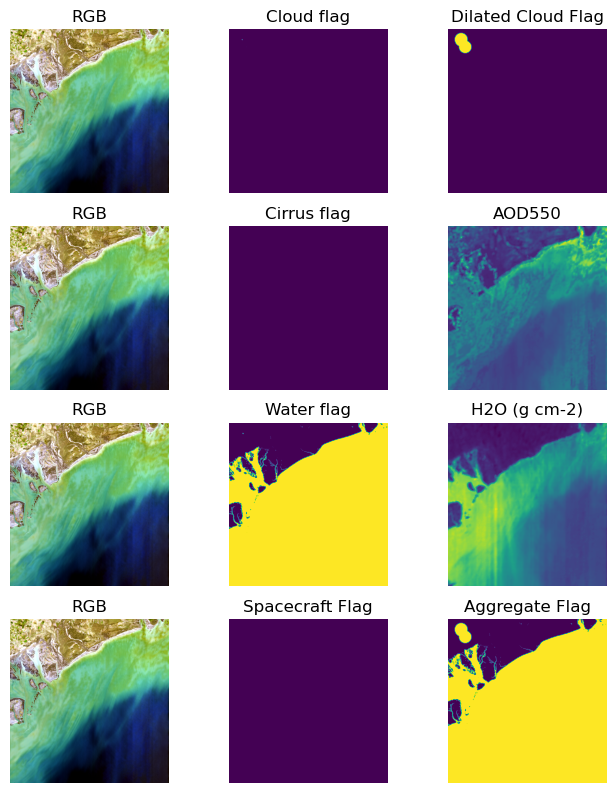

In [33]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8,20))
gs = gridspec.GridSpec(ncols=3, nrows=len(mask_key), figure=fig)

ds = emit_tools.emit_xarray(fp, ortho = False)
mask_ds = emit_tools.emit_xarray(fp_mask, ortho=False)

rgb_inds = np.array([np.nanargmin(abs(ds['wavelengths'].values - x)) for x in [650, 560, 470]])
rgb = ds['reflectance'].values[:,:,rgb_inds] # subset RGB
rgb -= np.percentile(rgb,2,axis=(0,1))[np.newaxis,np.newaxis,:] # scale from 2-98 %
rgb /= np.percentile(rgb,98,axis=(0,1))[np.newaxis,np.newaxis,:]

for _n in range(int(len(mask_key)/2)):
    ax = fig.add_subplot(gs[_n, 0])
    plt.imshow(rgb);
    plt.axis('off')
    plt.title('RGB')
    
    ax = fig.add_subplot(gs[_n, 1])
    plt.imshow(mask_ds['mask'].values[...,_n]);
    plt.axis('off')
    plt.title(mask_key['mask_bands'][_n])
    
    ax = fig.add_subplot(gs[_n, 2])
    plt.imshow(mask_ds['mask'].values[...,_n+int(len(mask_key)/2)]);
    plt.axis('off')
    plt.title(mask_key['mask_bands'][_n+int(len(mask_key)/2)])

Some of these bands are direct masks (Cloud, Dilated, Currus, Water, Spacecraft), and some (AOD550 and H2O (g cm-2)) are information calculated during the L2A reflectance retrieval that may be used as additional screening, depending on the application.  The final mask that the EMIT mission will use for its minerological applications is shown as the Aggreged Flag - but not all users might want this particular mask.

Let's take a closer look at some of those bands with additional information, that could be used either to screen specific content out or that might be used as signal:

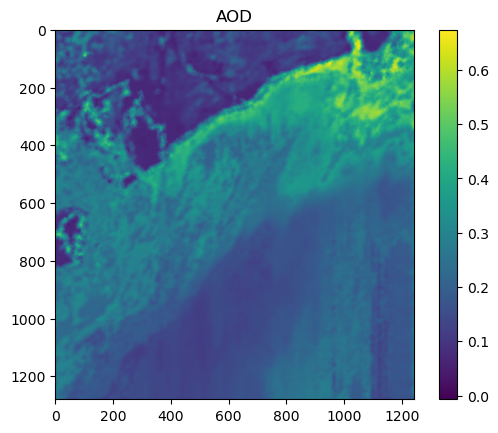

In [29]:
fig = plt.figure()

plt.imshow(mask_ds['mask'].values[:,:,list(mask_key['mask_bands']).index('AOD550')]);
plt.title('AOD550')
plt.colorbar()

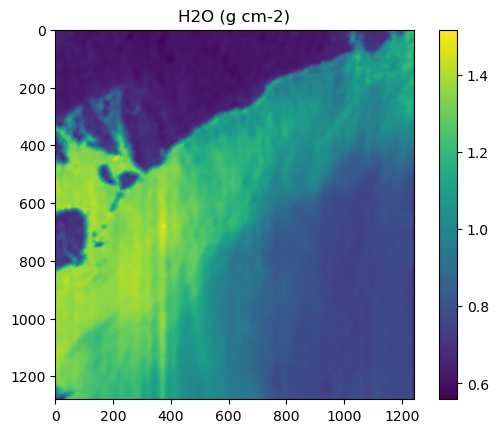

In [30]:
fig = plt.figure()

plt.imshow(mask_ds['mask'].values[:,:,list(mask_key['mask_bands']).index('H2O (g cm-2)')]);
plt.title('H2O (g cm-2)')
plt.colorbar()

# Applying the Mask

In [34]:
mask_key

mask_bands
bands                    
0              Cloud flag
1             Cirrus flag
2              Water flag
3         Spacecraft Flag
4      Dilated Cloud Flag
5                  AOD550
6            H2O (g cm-2)
7          Aggregate Flag

The above dataframe shows exactly what each band contained within the file represents/will mask. For this example we will use flags 0,1,3, and 4 to remove any potential clouds and any artefacts caused by the space station. This can be done using the `quality_mask` function from the `emit_tools` module. This function combines the requested flags into a single mask and returns it as an array.

Select the bands to use.

In [4]:
flags = [0,1,3,4]
flags

[0, 1, 3, 4]

Now create the mask using the `quality_mask` function.

In [5]:
mask = emit_tools.quality_mask(fp_mask,flags)

Flags used: ['Cloud flag' 'Cirrus flag' 'Spacecraft Flag' 'Dilated Cloud Flag']


To see the regions of the unorthocorrected image that will be masked we can plot the mask array.

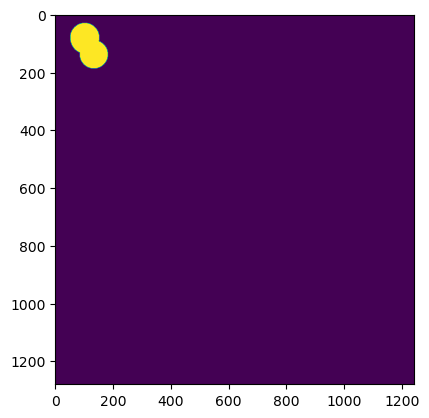

In [6]:
plt.imshow(mask)

Now that we have a mask to apply, we can use it as the `qmask` parameter in the `emit_xarray` function. 

In [7]:
ds = emit_tools.emit_xarray(fp, ortho=True, qmask=mask)
ds

<xarray.Dataset>
Dimensions:      (latitude: 2009, longitude: 2353, bands: 285)
Coordinates:
  * latitude     (latitude) float64 -39.31 -39.31 -39.31 ... -40.39 -40.4 -40.4
  * longitude    (longitude) float64 -62.51 -62.51 -62.51 ... -61.24 -61.24
    wavelengths  (bands) float32 ...
    fwhm         (bands) float32 ...
    spatial_ref  int32 0
Dimensions without coordinates: bands
Data variables:
    reflectance  (latitude, longitude, bands) float32 nan nan nan ... nan nan
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             -40.39610428069674
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-6.25120945e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Surface Reflectance 60 m V001

This `ds` dataset is now orthorectified and the specified mask has been applied. Visualize the output using a plot of a red band (650 nm).

In [35]:
red = np.nanargmin(abs(ds['wavelengths'].data-650)) # Find closes band to 650 - Red
ds.isel(bands=red).hvplot.image(cmap='viridis', aspect = 'equal', frame_width=500, rasterize=True)

:DynamicMap   []
   :Image   [crosstrack,downtrack]   (reflectance)

The modified `xarray.Dataset` can also be saved as a netCDF4 output that can be reopened using the `xarray.open_dataset` function.

In [9]:
ds.to_netcdf('../data/example_quality_nc_out.nc')
# Example for Opening 
# ds = xr.open_dataset('../data/example_quality_nc_out.nc')

## 2. Using EMIT Band Mask Data

The EMIT L2A Mask file also contains `band_mask` data, which indicates whether or not any given wavelength of any given pixel is interpolated. Interpolation occurs either due to a focal plane array bad pixel, or from saturation. This data comes as a packed unsigned integer array with 36 elements.

Unpack the data an using the `band_mask` function from the `emit_tools` module. This function will unpack the data and create an array that can be used to mask the bands/pixels when added as an input into the `emit_xarray` function.

In [10]:
bmask = emit_tools.band_mask(fp_mask)
bmask.shape

(1280, 1242, 285)

Quickly plot an example of a band where some pixels have been interpolated (band 234).

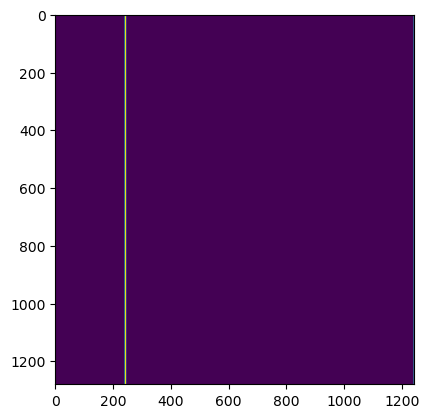

In [11]:
from matplotlib import pyplot as plt
plt.imshow(bmask[:,:,234])

Read in the EMIT L2A Reflectance Dataset and use `bmask`, setting the `unpacked_bmask` parameter equal to `bmask` to mask those bands. In this example we'll leave `ortho` as `False`.

In [12]:
ds = emit_tools.emit_xarray(fp, ortho = False, unpacked_bmask = bmask)

Plot to visualize the same pixels masked from the image as in the mask preview above for band 234.

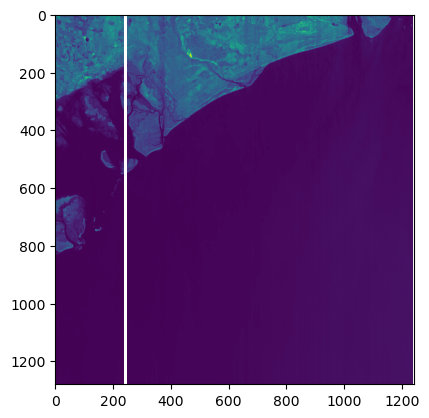

In [13]:
plt.imshow(ds['reflectance'].values[:,:,234])

Also for an orthorectified file, if desired.

In [ ]:
ds = emit_tools.emit_xarray(fp, ortho = True, unpacked_bmask = bmask)
ds.isel(bands=234).hvplot.image(cmap='viridis', aspect = 'equal', frame_width=500) #note `rasterize=True` here will cause the line of NA values to be invisible due to resampling.

---

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 01-18-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.  